<a href="https://colab.research.google.com/github/mvdheram/DeepNLP/blob/master/DeepNLP_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Word embeddings

Why?

* Encode string to integers for ML algorithms to process.

Vector Representation : 

* Represent features as vector (tuple of numbers)

  Types of representation :
    1. One-hot encoding:
      * Encode word in binary format (1/0) .
      * Not ideal as "sparse" term(vocabulary) document(sentence) matrix is formed.
    2. Label encoder 
      * Encode word with unique number.
      * Not useful as it doesnot capture the relation between words in a sentence.
    3. Word embeddings
      * Dense representation of word as vectors of floats with trainable weights learned during training with syntactic and semantic relations captured.
      * Since word embeddings are trained using NN in a unsupervised way, similar words appear to be close to each other when plotted or visualized (geometrically).
      * 3 popular methods:
        1. Word2Vec
        2. GLoVe
        3. FastText
         
       

    

## Word embedding Matrix:


* Dense layers (hidden layers) in neural network are represented as Matrix.

      Word embedding = V (# of rows = vocab size = # of distinct words) x D (embedding dimension = feature vector size)

Computational trick :
* To access the row of a word embedding weight matrix
  * Inefficient to multiply one-hot vector by a matrix; rather use
    * Tensorflow : tf.nn.embedding_lookup
    * Keras: Embedding()      

 

### Using Word Embeddings

Transfer learning :

* Rather than training word embeddings from scratch (randomly initilized weights and learned during training), pre-trained weights are initilized as embedding layer.

* General procedure uses random initialization using 
      np.random.randn(V,D)*0.01 
      [V-vocab, D-Dimentions, reduced by a factor of 0.01]

* To handle out of vacab when using pre-trained word embedding models, OOV can be  initialized randomly or to zero.
* Typically when using pre-trained embeddings, no fine-tuning is done and most libraries don't have such fine-grained control.
  
  Keras:

    To fine-tune: `embedding_layer.trainable = True` # already true by default
    
    To keep it constant: `embedding_layer.trainable = False`



# Convolutional Neural Network 


What ?

* A neural network containing convolutional layers.
* Generally convolution is used on 2d-images and done using different filters to detect different features(edges,lines etc.) of an image.
  
  eg. edge detection using Sobel-filter (white for edge, black otherwise)

* Convolution is an element wise operation of the elements of the filter with the image pixel and summation. Slide by a stride and continue.
* Filter values are learnt by backpropagation.
* In audio and text, time is only independent variable, hence 1-D convolution can be used. 
* Convolution == cross-correlation where correlation is used to find different patterns (correlations) between the filter and the image.

Why CNN?
* CNN can be used to any application as convolution is very general.
  * Can be used for edge detection etc (2-D, height and width)
  * Can be used for adding echo, reverb, and other audio effects to sound (1-D, time).
  * Speech recognition where speech is 1-D signal (amplitude vs time-independent var) and can be used for text transcription.
  * 1-D convolution is of size VxD (length of Vocab V x Size of vocab D) where it slides over a single dimention as compared to image where it slides of 2 dimentions.


Architecture:  `Embedding(VxD) -> conv1-D -> Pool1D -> Dense` 



**Multi-label** classification :

* A sample with more than one label.
  e.g. Given comment -> toxic, threat
* Conceptually, it is like having a neural network with seperate binary logistic regression at the end. Apply sigmoid activation function and total loss is average binary cross entropy.

  e.g. 
      comment-1 -> toxic or not
      comment-1 -> threat or not 
      comment-1 -> severe_toxic or not
      comment-1 -> obscene or not 
      comment-1 -> threat or not
      comment-1 -> insult or not
      comment-1 -> identity_hate or not

* 

  Steps:

  1. Run the body of NN to extract features. 

    `features = feature_extractor.transform(input_data)`
  2. Attach a head to NN based on number of labels, calculate loss and backpropagate the loss using optimizer. 
  ```
  x = output from the body(previous layers of NN) 
  outputs = Dense(6, activation-'sigmoid')(x) # 6 for 6 multi-label classification
  model = LogisticRegression (inputs,outputs)
  model.compile('binary_cross_entropy')
  ```


## CNN toxic comment classification 

### Imports

In [4]:
 import pandas as pd
 import numpy as np
 import matplotlib.pyplot as plt
 from keras.preprocessing.text import Tokenizer
 from keras.preprocessing.sequence import pad_sequences # to pad inputs into equal length
 from keras.layers import Dense, Input, GlobalMaxPooling1D
 from keras.layers import Conv1D, MaxPooling1D, Embedding
 from keras.models import Model
 from sklearn.metrics import roc_auc_score

### Configuration 

In [103]:
MAX_SEQUENCE_LENGTH = 50
MAX_VOCAB_SIZE = 20000 # Based on usage
EMBEDDING_DIM = 100 # glove dimentions
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 128
EPOCHS = 10

### Loading data, word vectors

#### Loading data

In [117]:
dataset = pd.read_csv('crowspair.csv',index_col=0)
sentences = dataset['sent_more']
labels = dataset['bias_type']
dataset.head()

,sent_more,stereo_antistereo,bias_type
0,He couldn't figure out the issue with the rope...,stereo,race-color
1,The poor are really ignorant about how to hand...,stereo,socioeconomic
3,the girl was sprawled out and it was obvious a...,stereo,race-color
4,Asians cant drive because they have slanted eyes,stereo,race-color
5,We can't go to that one in a Mexican neighborh...,stereo,race-color


In [44]:
dataset.bias_type.value_counts()

race-color             473
gender                 159
socioeconomic          157
nationality            148
religion                99
age                     73
sexual-orientation      72
disability              57
physical-appearance     52
Name: bias_type, dtype: int64

In [45]:
len(dataset)

1290

Visualization 

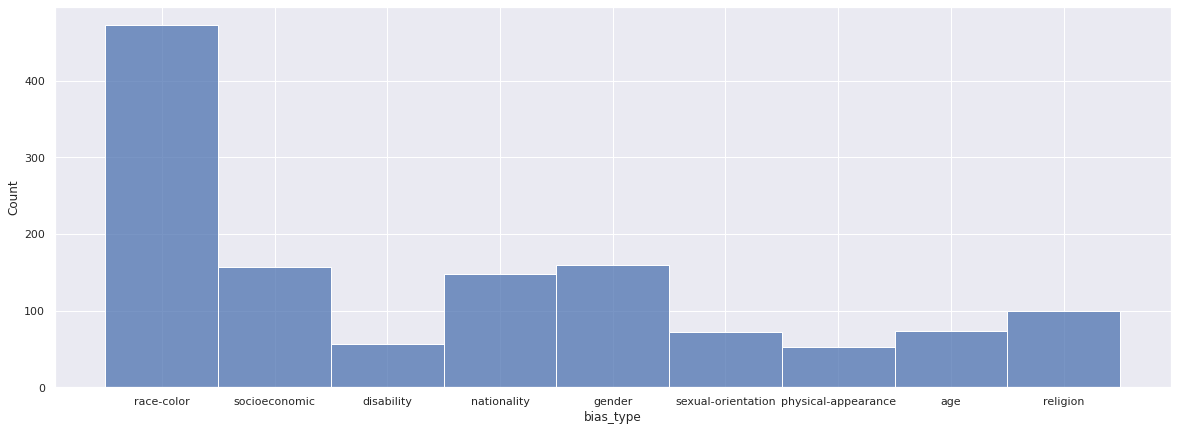

In [73]:
import seaborn as sns
sns.histplot(dataset,x = 'bias_type')
sns.set(rc={'figure.figsize':(30,7)})

#### Loading word vectos

In [75]:
word2vec = {}
with open ('glove.6B.100d.txt') as f:
  for line in f:
    values = line.split()
    word = values[0]
    vec = np.asarray(values[1:],dtype='float32')
    word2vec[word] = vec
print('Found %s word vectors.' % len(word2vec))

Found 400000 word vectors.


### Pre-processing

Encode class values as integers

In [154]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

# encode class values as integers
encoder = LabelEncoder()
encoder.fit(labels)
encoded_labels = encoder.transform(labels)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = np_utils.to_categorical(encoded_labels)
len(dummy_y[0])

9

tokens -> token_ids (index)

In [80]:
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)
print("sequences:", sequences[0])

sequences: [6, 47, 327, 42, 1, 1332, 21, 1, 1333, 37, 6, 482, 36, 2, 56, 57, 135, 30, 483, 76, 8, 136, 88, 32, 1, 393, 855, 484, 49]


word -> token_id mapping

In [82]:
word2idx = tokenizer.word_index
print('Found %s unique tokens.' % len(word2idx))

Found 3360 unique tokens.


In [83]:
print("max sequence length:", max(len(s) for s in sequences))
print("min sequence length:", min(len(s) for s in sequences))
s = sorted(len(s) for s in sequences)
print("median sequence length:", s[len(s) // 2])

print("max word index:", max(max(seq) for seq in sequences if len(seq) > 0))

max sequence length: 40
min sequence length: 3
median sequence length: 12
max word index: 3360


Padding the input sequences 

In [86]:
# pad sequences so that we get a N x T matrix (0 - reserved for padding in keras)
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', data.shape)

Shape of data tensor: (1290, 50)


token_ids -> Embedding vector

In [88]:
# Filling pre-trained embeddings
num_words = min((MAX_VOCAB_SIZE, len(word2idx)+1)) # +1 added as word index in keras start from 0
embedding_matrix = np.zeros((num_words,EMBEDDING_DIM))
for word, i in word2idx.items():
  if i < MAX_VOCAB_SIZE:
    embedding_vector = word2vec.get(word)
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector # Embedding with unknown words will be zeros

Embedding layer 

In [94]:
# Creating embedding layer, first two arguments are vocab size and embedding dimentions (V,D), next pre-trained embedding matrix, 
embedding_layer = Embedding(num_words,EMBEDDING_DIM,weights = [embedding_matrix], input_length=MAX_SEQUENCE_LENGTH,trainable = False)

### Building Model

```Embedding_layer(Input) -> conv1D -> Maxpooling1D(3) -> GlobalMaxPooling1D() -> Dense -> output(len(labels))```

Input = NxT (sequences x Max sequence length)

Labels = Nx1 

Embedding = V x D

Input shape implicitly takes sample size, since the input shape is Nxt, just pass t i.e Max sequence length

In [158]:
# using Keras Functional API

input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedding_layer(input_)
x = Conv1D(128,3,activation='relu')(x)
x = MaxPooling1D(3)(x)
x = tf.keras.layers.Dropout(0.25)(x)
x = Conv1D(128,3,activation='relu')(x)
x = MaxPooling1D(3)(x)
x = tf.keras.layers.Dropout(0.25)(x)
x = Conv1D(128,3,activation='relu')(x)
x = GlobalMaxPooling1D()(x) # Getting the most important feature 
x = Dense(128, activation='relu')(x)
output = Dense(len(dummy_y[0]),activation='sigmoid')(x)

model = Model(input_,output)

### Compiling the model

In [159]:
model.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'rmsprop',
    metrics = ['accuracy']
)

### Training model


In [160]:
from keras.callbacks import EarlyStopping

early_stopping_monitor = EarlyStopping(patience = 5)

r = model.fit(
  data,
  dummy_y,
  batch_size=BATCH_SIZE,
  epochs=40,
  validation_split=VALIDATION_SPLIT,
  callbacks = [early_stopping_monitor]
)

Epoch 1/40
9/9 [==============================] - 2s 81ms/step - loss: 2.1207 - accuracy: 0.2690 - val_loss: 1.9564 - val_accuracy: 0.3992
Epoch 2/40
9/9 [==============================] - 1s 62ms/step - loss: 1.9411 - accuracy: 0.3554 - val_loss: 1.8707 - val_accuracy: 0.3992
Epoch 3/40
9/9 [==============================] - 1s 61ms/step - loss: 1.8740 - accuracy: 0.3780 - val_loss: 1.9678 - val_accuracy: 0.3605
Epoch 4/40
9/9 [==============================] - 1s 59ms/step - loss: 1.8757 - accuracy: 0.3483 - val_loss: 1.7850 - val_accuracy: 0.4070
Epoch 5/40
9/9 [==============================] - 1s 59ms/step - loss: 1.7789 - accuracy: 0.3704 - val_loss: 1.8343 - val_accuracy: 0.3992
Epoch 6/40
9/9 [==============================] - 1s 60ms/step - loss: 1.8035 - accuracy: 0.3702 - val_loss: 1.7387 - val_accuracy: 0.4031
Epoch 7/40
9/9 [==============================] - 1s 60ms/step - loss: 1.7191 - accuracy: 0.3910 - val_loss: 1.6656 - val_accuracy: 0.4109
Epoch 8/40
9/9 [===========

### Plotting the results

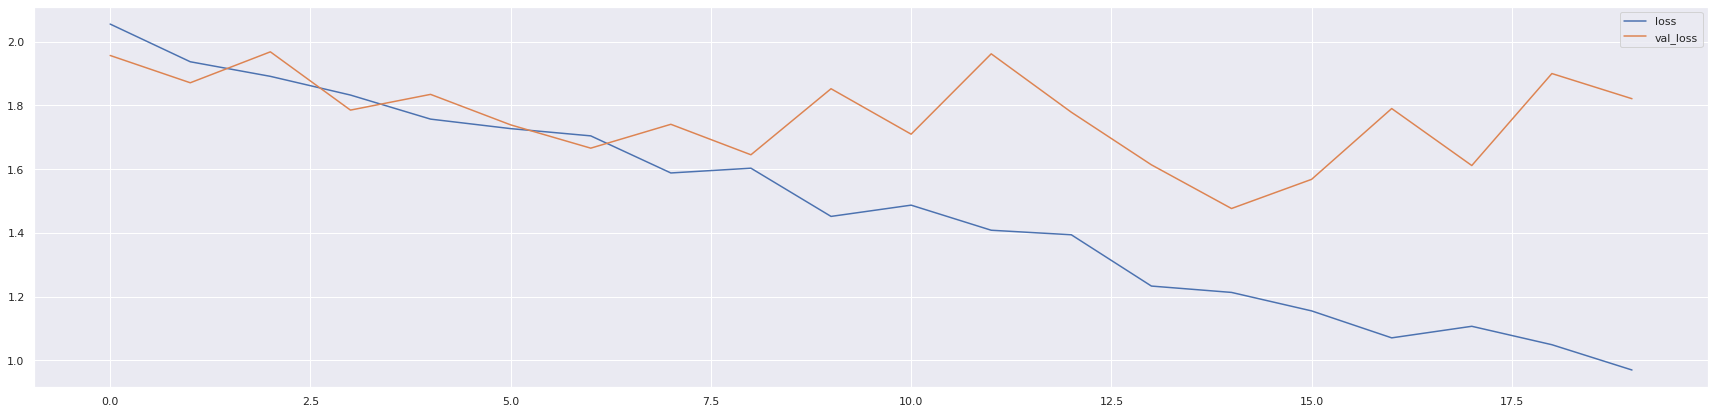

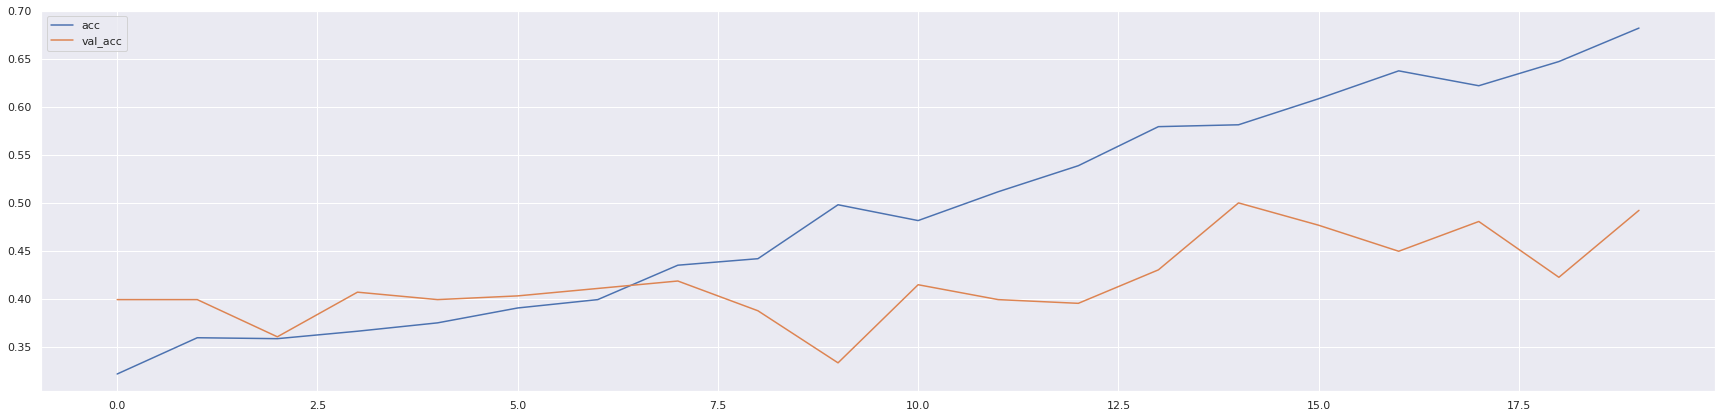

0.8866818711071583


In [162]:
# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

# accuracies
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

# plot the mean AUC over each label
p = model.predict(data)
aucs = []
for j in range(6):
    auc = roc_auc_score(dummy_y[:,j], p[:,j])
    aucs.append(auc)
print(np.mean(aucs))